# Structure MCMC Tests

In [1]:
import numpy as np
import pandas as pd
import arviz as az

import networkx as nx
from mcmc.structure_mcmc import *
from mcmc.visualisation import *
from mcmc.utils import *
from mcmc.scores import *
from mcmc.graph_utils import *
from mcmc.diagnostics import *


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


## Test 1: Three Nodes

### Data Generation Process

In [2]:
def generate_data_3nodes(params, n_samples=1000 ):
    
    # Generate exogenous variables X
    X2 = np.random.normal(0, params["sigma_x2"], n_samples)
    X3 = np.random.normal(0, params["sigma_x3"], n_samples)
    
    # Generate X1 based on the regression model
    epsilon = np.random.normal(0, params["sigma_epsilon"], n_samples)
    X1 = params["beta0"] + params["beta2"] * X2 + params["beta3"] * X3 + epsilon
    
    df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3})
    
    return df

In [29]:
# specify regression and noise parameters
data_t1_params = {}
data_t1_params["beta0"] = 1
data_t1_params["beta2"] = 3.0
data_t1_params["beta3"] = -2.0
data_t1_params["sigma_x2"] = 1
data_t1_params["sigma_x3"] = 1
data_t1_params["sigma_epsilon"] = 0.1

# generate data
data_t1 = generate_data_3nodes(data_t1_params, n_samples=200)
data_t1

,X1,X2,X3
0,6.909319,0.192589,-2.728570
1,-6.014017,-0.985972,2.010818
2,5.485999,-0.618163,-3.075075
3,2.090799,0.591553,0.436292
4,4.467970,-0.002845,-1.821466
...,...,...,...
195,6.337548,0.522128,-1.915874
196,5.961113,1.967636,0.510182
197,1.585497,-0.641129,-1.346192
198,4.714508,1.115833,-0.120429


### Theoretical Distribution Analysis

In [30]:
DATA = data_t1




### Structure MCMC

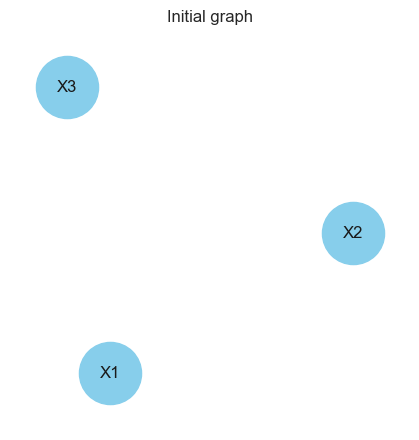

In [31]:
# specify initial graph
empty_graph = nx.DiGraph()
empty_graph.add_nodes_from(DATA.columns)

plot_graph(empty_graph, title="Initial graph")


In [32]:
NUM_ITERATIONS = 1000

print("Starting MCMC...")
mcmc = StructureMCMC( DATA, NUM_ITERATIONS, empty_graph, score_function = "Log_Marginal_Likelihood")
scores_dict = mcmc.run( random_restarts = True, restart_freq=100)
print( f"Acceptance Rate: {scores_dict['acceptance_rate']}")
print("Finished MCMC")


Starting MCMC...
Acceptance Rate: 0.035
Finished MCMC


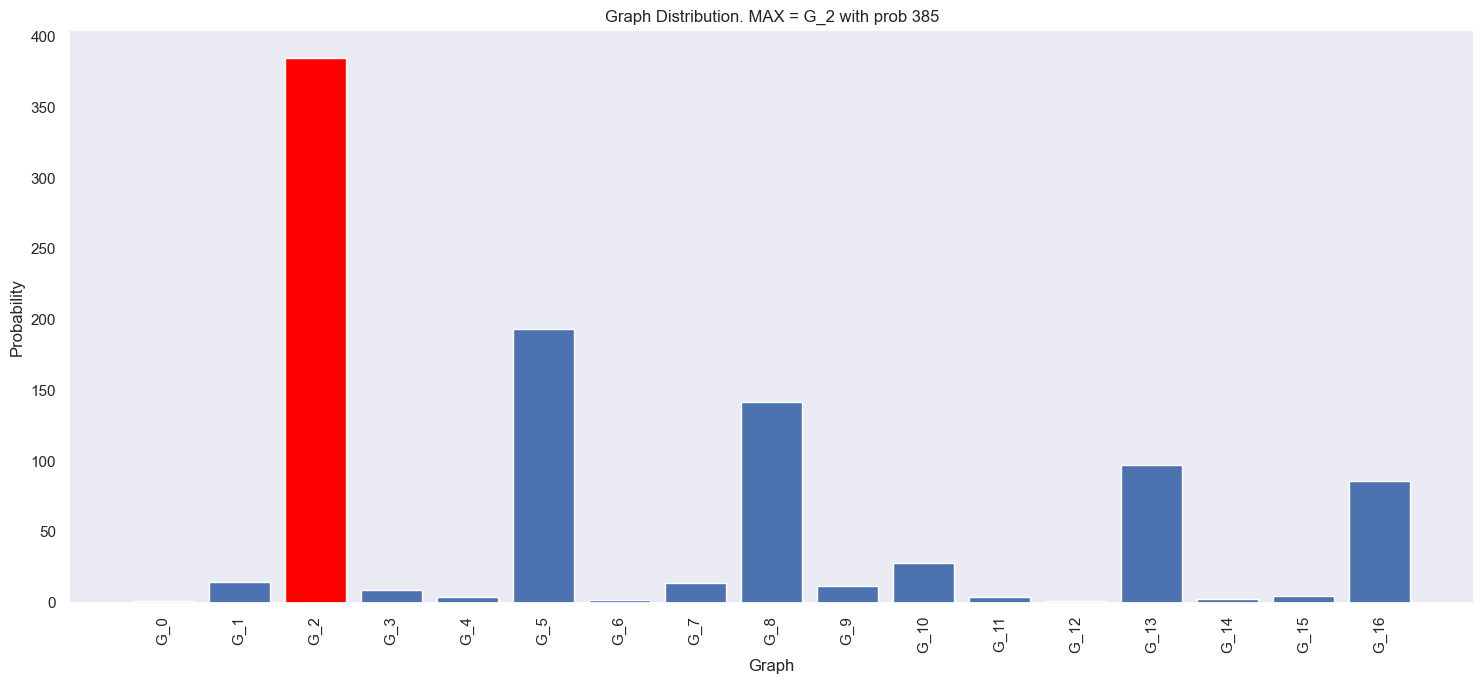

(['G_2'], 385)

In [33]:

graph_distribution, graphs, scores = generate_graph_distribution( scores_dict['graphs'], DATA )
mcmc_graph_distribution_plot( graph_distribution )


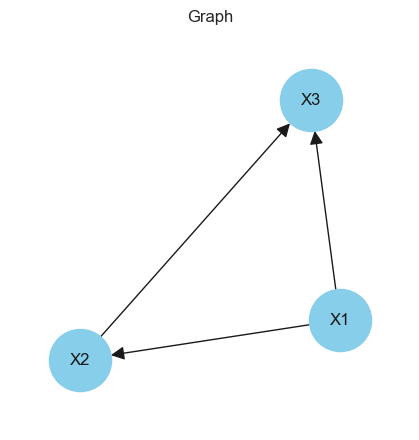

In [34]:
plot_graph(graphs["G_2"])

In [35]:
# burnit
BURNIT = 200
posteriors['marginal_likelihood'] = posteriors['marginal_likelihood'][BURNIT:]
graph_candidates = graph_candidates[BURNIT:]
np.mean(posteriors['marginal_likelihood'])

NameError: name 'posteriors' is not defined

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (1001) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (1001) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


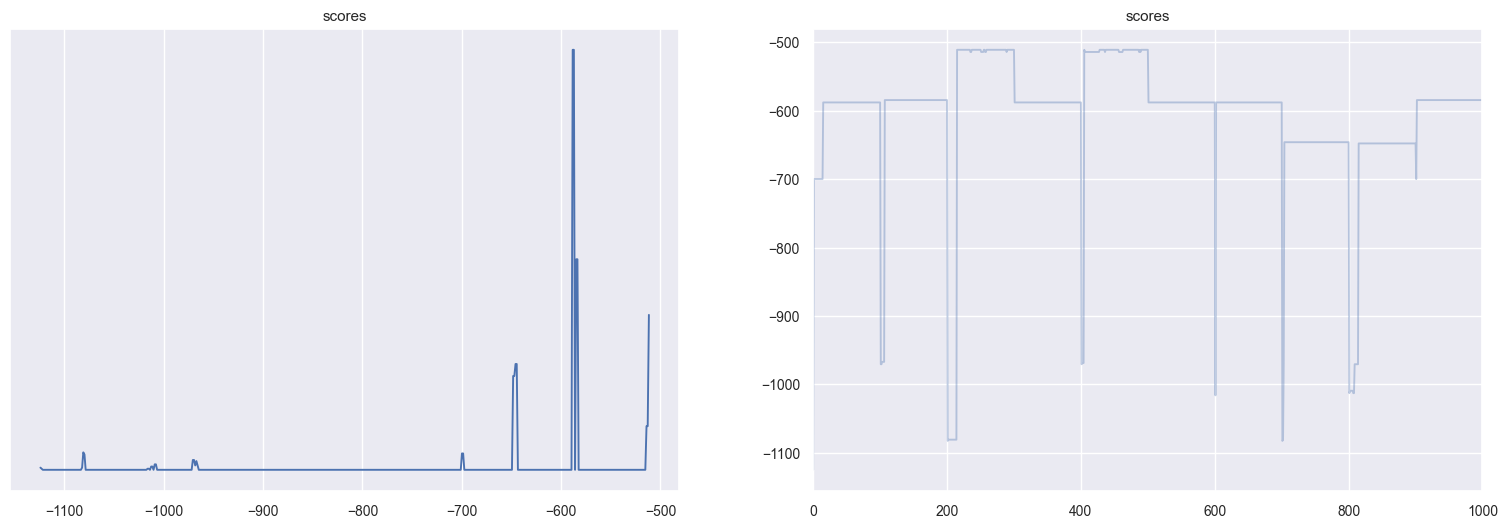

In [39]:
az.plot_trace(scores_dict, var_names=["scores"], figsize=(19, 6));

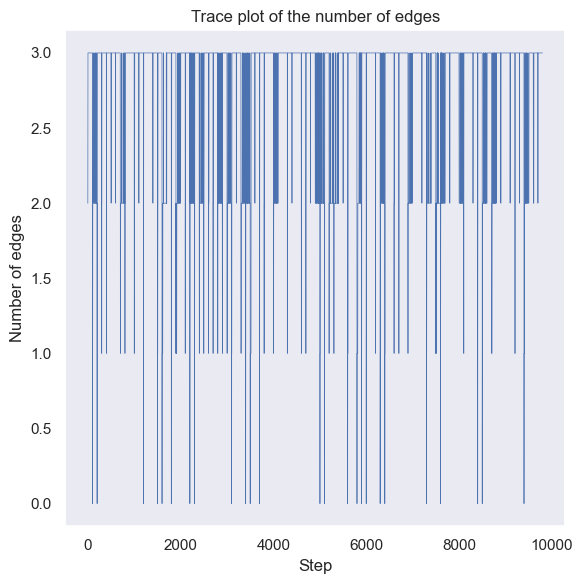

In [ ]:

plot_edges_trace( graph_candidates, figsize=(6, 6))

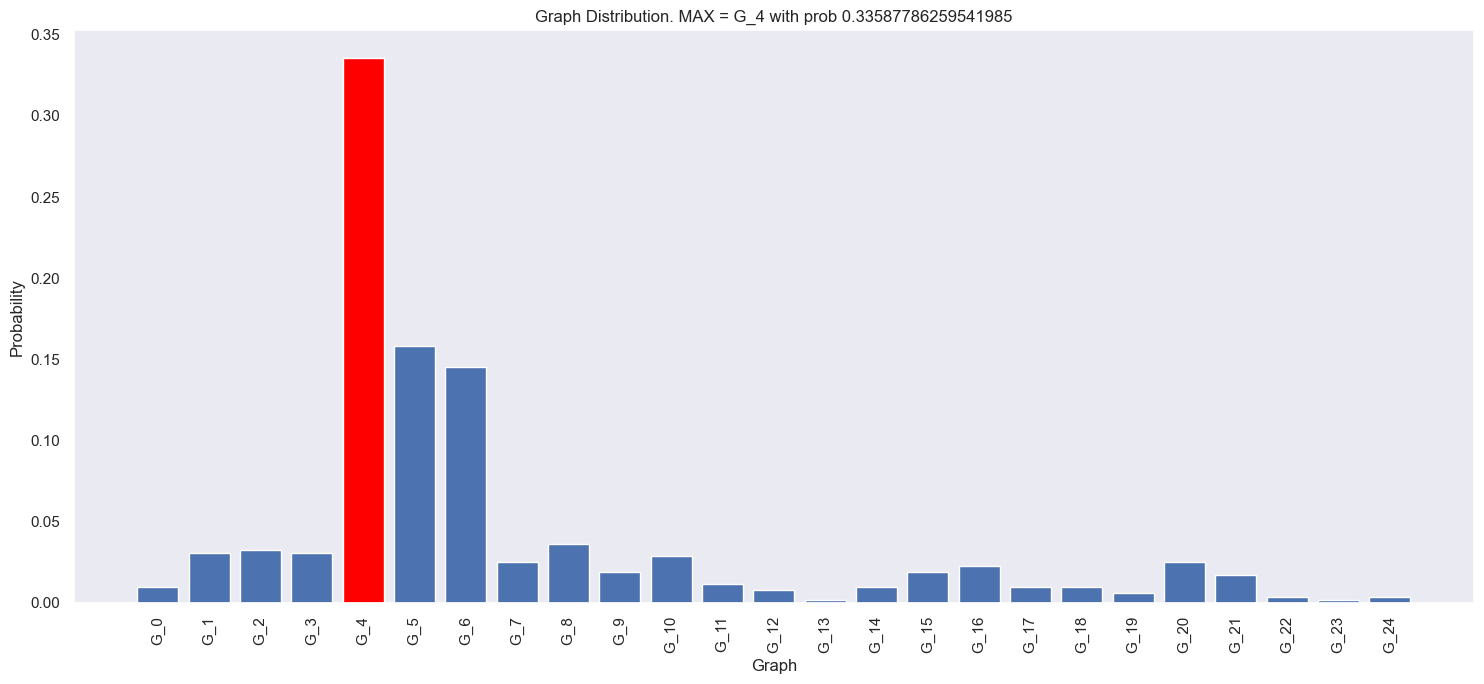

In [ ]:
max_labels, max_freq = plot_graph_distribution( normalise_Gs(Gs) )

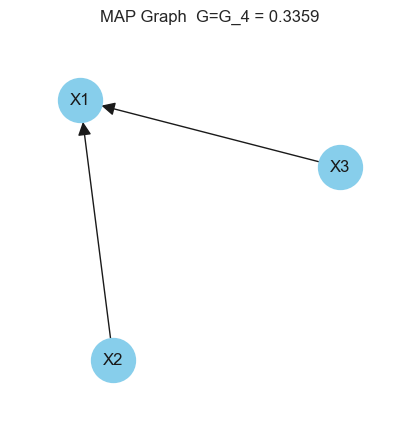

In [ ]:
for label in max_labels:
    plot_graph( graphs[label], f"MAP Graph  G={label} = {np.round(max_freq,4)}", node_size = 1000)

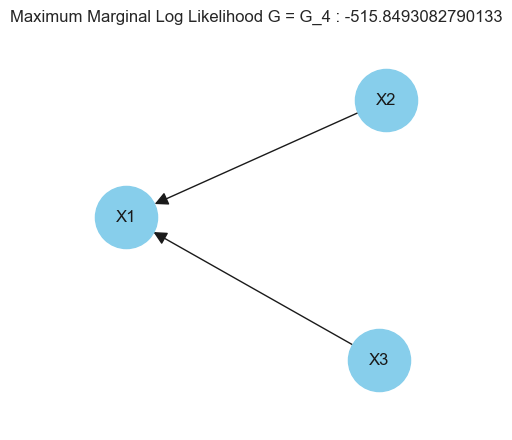

In [ ]:
# find the max of  posteriors['marginal_likelihood'] and return its index
max_indx = np.argmax( posteriors['marginal_likelihood'] )
graph_ID = my_hash[ graph_hash( graph_candidates[max_indx] ) ]

plot_graph( graph_candidates[max_indx], f"Maximum Marginal Log Likelihood G = {graph_ID} : {posteriors['marginal_likelihood'][max_indx]}" )


In [ ]:
params[graph_ID]

{'X1': {'Lambda_n': array([[200.1]]),
  'm_n': array([1.08169363]),
  'a_n': 101.0,
  'b_n': 1456.6751990852779},
 'X2': {'Lambda_n': array([[ 200.1       ,  216.44689473],
         [ 216.44689473, 3145.57962475]]),
  'm_n': array([-0.22431973,  0.21373423]),
  'a_n': 101.0,
  'b_n': 28.689400116487477},
 'X3': {'Lambda_n': array([[200.1]]),
  'm_n': array([-0.02883195]),
  'a_n': 101.0,
  'b_n': 110.82277447068061}}

In [ ]:
sampled_params = sample_parameters( params[graph_ID] )
sampled_params

{'X1': {'beta': 1.2433284904480566, 'sigma2': 15.453635069286445},
 'X2': {'beta': array([-0.26165872,  0.21662787]),
  'sigma2': 0.26311889676191896},
 'X3': {'beta': 0.032406847198343594, 'sigma2': 1.139666146491904}}

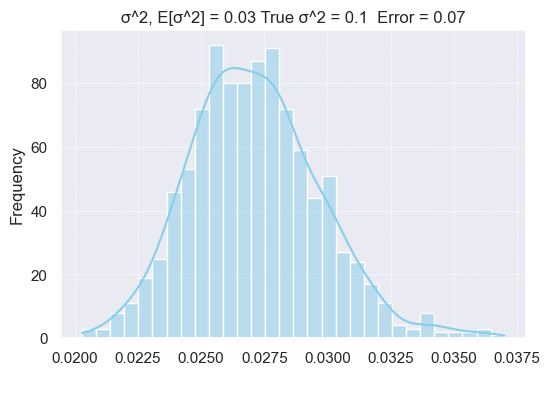

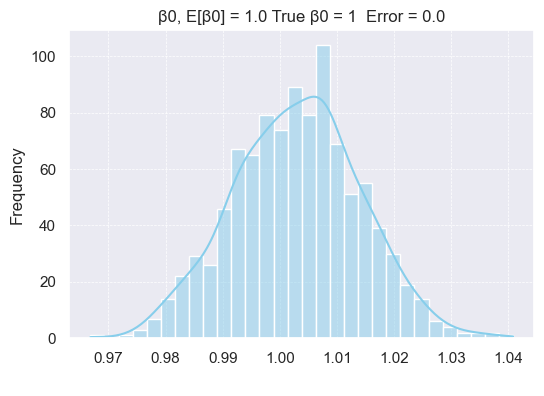

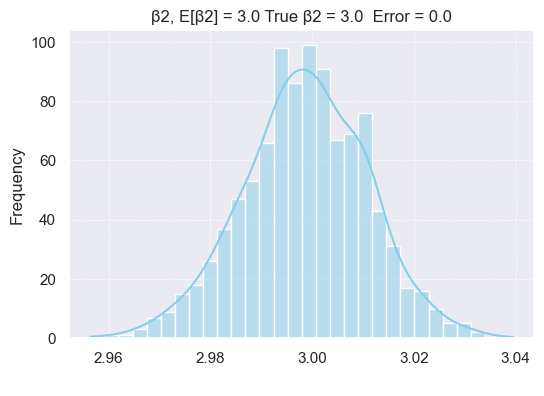

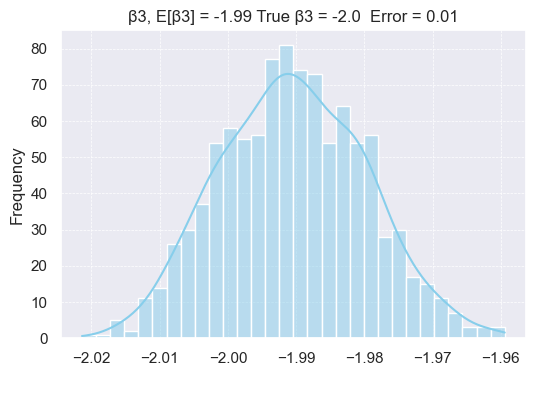

In [ ]:
num_samples = 1000

outputs = []
sigmas2 = []
beta0s = []
beta2s = []
beta3s = []

score = MarginalLikelihood(DATA, graph_candidates[max_indx])
max_score, max_params = score.compute()

for i in range(num_samples):
    sampled_params = sample_parameters( max_params )
    
    # get params for X1 (our regression node)
    sigmas2.append( sampled_params["X1"]["sigma2"] )
    
    # get regression coefficients
    beta0s.append( sampled_params["X1"]["beta"][0] )
    beta2s.append( sampled_params["X1"]["beta"][1] )
    beta3s.append( sampled_params["X1"]["beta"][2] )
    
error_sigma2 = np.round( np.abs(data_t1_params['sigma_epsilon'] - np.mean(sigmas2) ), 2)
plot_histogram(sigmas2, title = f"σ^2, E[σ^2] = {np.round(np.mean(sigmas2),2)} True σ^2 = {data_t1_params['sigma_epsilon']}  Error = {error_sigma2}", xlabel=" ", figsize=(6,4))

error_beta0 = np.round( np.abs(data_t1_params['beta0'] - np.mean(beta0s) ), 2)
plot_histogram(beta0s, title = f"β0, E[β0] = {np.round(np.mean(beta0s),2)} True β0 = {data_t1_params['beta0']}  Error = {error_beta0}", xlabel=" ",figsize=(6,4))

error_beta2 = np.round( np.abs(data_t1_params['beta2'] - np.mean(beta2s) ), 2)
plot_histogram(beta2s, title = f"β2, E[β2] = {np.round(np.mean(beta2s),2)} True β2 = {data_t1_params['beta2']}  Error = {error_beta2}", xlabel=" ",figsize=(6,4))

error_beta3 = np.round( np.abs(data_t1_params['beta3'] - np.mean(beta3s) ), 2)
plot_histogram(beta3s, title = f"β3, E[β3] = {np.round(np.mean(beta3s),2)} True β3 = {data_t1_params['beta3']}  Error = {error_beta3}", xlabel=" ",figsize=(6,4))
